In [69]:
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use(['science', 'notebook'])

import pyopencl as cl
from scipy.stats import qmc
import numpy.linalg as la

import time
from datetime import datetime

print('Start', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Start 2025-03-30 15:16:37


### Major difference with v3
* let cpuPso and gpuPso handle their random and initial position/velocity/r1/r2 separately
* the number of iterations in pure_CPU, OpenCL_CPU, OpenCL_GPU are random due to non-uniform initial positions/velocity/r1/r2

### Heterogeneous Parallel Computing check & setup OpenCL environment

In [70]:
def print_device_info() :
    print('\n' + '=' * 60 + '\nOpenCL Platforms and Devices')

    for platform in cl.get_platforms():
        print('=' * 60)
        print('Platform - Name: ' + platform.name)
        print('Platform - Vendor: ' + platform.vendor)
        print('Platform - Version: ' + platform.version)
        print('Platform - Profile: ' + platform.profile)

    for device in platform.get_devices():
        print(' ' + '-' * 56)
        print(' Device - Name: ' \
        + device.name)
        print(' Device - Type: ' \
        + cl.device_type.to_string(device.type))
        print(' Device - Max Clock Speed: {0} Mhz'\
        .format(device.max_clock_frequency))
        print(' Device - Compute Units: {0}'\
        .format(device.max_compute_units))
        print(' Device - Global Memory: {0:.0f} GB'\
        .format(device.global_mem_size/ 2**30))
#         print(' Device - Global cache: {0:.0f} KB'\
#         .format(device.global_mem_cache_size/ 2**10))
        print(' Device - Constant Memory: {0:.0f} GB'\
        .format(device.max_constant_buffer_size/ 2**30))
        print(' Device - Local Memory: {0:.0f} KB'\
        .format(device.local_mem_size/ 2**10),  '('+cl.device_local_mem_type.to_string(device.local_mem_type)+')')
    
        
        print(' Device - Max Buffer/Image Size: {0:.0f} GB'\
        .format(device.max_mem_alloc_size/ 2**30))
        print(' Device - Max Work Group Size: {0:.0f}'\
        .format(device.max_work_group_size))
#         print('\n') 
        
print_device_info()


OpenCL Platforms and Devices
Platform - Name: Apple
Platform - Vendor: Apple
Platform - Version: OpenCL 1.2 (Dec 13 2024 23:09:21)
Platform - Profile: FULL_PROFILE
 --------------------------------------------------------
 Device - Name: Apple M1
 Device - Type: ALL | GPU
 Device - Max Clock Speed: 1000 Mhz
 Device - Compute Units: 8
 Device - Global Memory: 5 GB
 Device - Constant Memory: 1 GB
 Device - Local Memory: 32 KB (LOCAL)
 Device - Max Buffer/Image Size: 1 GB
 Device - Max Work Group Size: 256


In [71]:
# ready the PyOpenCL environment
platform = cl.get_platforms()[0]

device = platform.get_devices(cl.device_type.GPU)[0]
# device = platform.get_devices(cl.device_type.CPU)[0]
print('Initializing opencl context on', cl.device_type.to_string(device.type).rpartition(' ')[2])

context = cl.Context([device])

gpu_queue = cl.CommandQueue(context, properties=cl.command_queue_properties.PROFILING_ENABLE)

# program = cl.Program(context, open('PSO-kernel.cl').read()).build()

deviceName = 'OpenCL_' + cl.device_type.to_string(device.type).rpartition(' ')[2]
print('device name:', deviceName)

Initializing opencl context on GPU
device name: OpenCL_GPU


In [4]:
# a = cl.device_type.to_string(device.type)
# a.rpartition(' ')[2]

##### Define kernel source

In [5]:
knl_source_mc = '''
#define n_PATH %d
#define n_PERIOD %d

__kernel void getEuroOption(__global float *Z, float S0, float K, float r, float sigma, float T, 
    char opt, __global float *out){
    
    /* pre calc dt, nudt, volsdt, lnS0*/
    private float dt = T / n_PERIOD;
    private float nudt = (r - 0.5* sigma*sigma) * dt;
    private float volsdt = sigma * sqrt(dt);
    private float lnS0 = log(S0);
    
    /* one thread per path, gid is current working thread/path */
    int path_id = get_global_id(0);
    
    float St = S0;
    float last_tmp = S0;
    float deltaSt = 0.0f;
    
    // simulate log normal price
    /* loop thru n_PERIOD for each path to get maturity price */
    for(int cur_t = 0; cur_t < n_PERIOD; cur_t++){
        last_tmp = deltaSt;      // set St to lastSt for next period calc
        /* get corresponding z */
        float z = Z[cur_t * n_PATH + path_id]; 
        deltaSt = nudt + volsdt * z;
        deltaSt += last_tmp;
    }
    St = exp(deltaSt + lnS0);

    /* return St at maturity */
    //out[path_id] = St;    
    
    /* return C_hat of Euro option */
    float path_C_hat = exp(-r*T) * max(0.0f, (K - St)*opt);
    out[path_id] = path_C_hat; 
}

__kernel void psoAmerOption_gb(global float *St, global float *pso, global float *C_hat, 
                        global int *boundary_idx, global float *exercise,
                        float r, float T, float K, char opt){
    
    //global invocation, each thread takes care of one fish, against full St, to compute fish cost
    int gid = get_global_id(0);            //thread id, per fish
    int nParticle = get_global_size(0);    //number of fishes
    
    int boundary_gid;                 // define shared global access id for boundary_idx & exercise
    float cur_fish_prd = 0.0f;        // tmp fish at period prd
    float cur_St_path_prd = 0.0f;     // tmp St of current path for same period prd
    
    int cur_period = 0;               // period indicator, indexing from 1 to N
    int st_id = 0;                    // St full matrix indicator, for n_PERIOD * n_PATH
    
    /* set intermediate arrays of index and exercise */
    //loop thru fish's periods
    //#pragma unroll   ---> counterproductive, do NOT unroll
    for (int prd=0; prd < n_PERIOD; prd++){
        //gid=0: prd:[0, 1, 2] nParticle=2 -> 0 + [0 1 2]*2 =  0, 2, 4
        //gid=1: prd:[0, 1, 2] nParticle=2 -> 1 + [0 1 2]*2 =  1, 3, 5
        cur_fish_prd = pso[gid + prd * nParticle];    // get thread-fish period value
        cur_period++;

        //loop thru all St paths at current period
        //#pragma unroll   ---> counterproductive, do NOT unroll
        for (int path= 0; path < n_PATH; path++){
            //prd: 0  path:[0, 1, 2, 3]   thread accessing: 0, 1, 2, 3
            //prd: 1  path:[0, 1, 2, 3]   thread accessing: 4, 5, 6, 7
            st_id = prd * n_PATH + path;    // calc St 'global' index
            cur_St_path_prd = St[st_id];    // get St path value at same period
            
            boundary_gid = gid + path * nParticle;  // calc shared global access id for boundary_idx & exercise
            
            // check if first cross: 1) pso > St; 2) corresponding boundary index not set from previous loops
            if (cur_fish_prd > cur_St_path_prd && boundary_idx[boundary_gid]==0){  
                boundary_idx[boundary_gid] = cur_period;     //store crossover time step
                exercise[boundary_gid] = cur_St_path_prd;     //store crossover price
            } 
            
            // if no cross for certain path, set index to last time step and exercise to path last price
            // check if no cross: 1) current period is last period; 2) boundary index not set from previous loops
            if (cur_period == n_PERIOD  &&  boundary_idx[boundary_gid]==0){    
                boundary_idx[boundary_gid] = n_PERIOD;             // set index to maturity time step
                exercise[boundary_gid] = cur_St_path_prd;          // exercise price at maturity
            }
        }
    }
    
    /* calc C_hat for current fish */
    float tmp_C = 0.0f;
    float dt = T / n_PERIOD;
    // input parameter opt is the Put/Call flag, 1 for Put, -1 for Call
    for (int path = 0; path < n_PATH; path++){         // sum all path C_hat
        boundary_gid = gid + path * nParticle;         // calc shared global access id for boundary_idx & exercise
        tmp_C += exp(-r * boundary_idx[boundary_gid] * dt) * max(0.0f, (K - exercise[boundary_gid]) * opt);
    }
    
    C_hat[gid] = tmp_C / n_PATH;     // get average C_hat for current fish/thread
    
    // reset intermediate buffer for next iteration
    for (int path = 0; path < n_PATH; path++){         
        boundary_gid = gid + path * nParticle;        // calc shared global access id for boundary_idx & exercise
        boundary_idx[boundary_gid] = 0;
        exercise[boundary_gid] = 0.0f;
    }
}

'''

knl_source_pso = '''
#define n_Dim %d

/* update nParticle positions & velocity, each thread handles on particle */
__kernel void searchGrid(global float *position, global float *velocity, 
                        global float *pbest_pos, global float *gbest_pos,
                        global float *r1, global float *r2, float w, float c1, float c2){
                        
    int gid = get_global_id(0);              // thread id presenting one particle
    int fish_size = get_global_size(0);      // number of threads/particles
    int item_id = 0;                         // item_id for accessing position, velocity, pbest_pos, r1, r2
    
    /* global memory access, this one works!! */
    for (int i=0; i<n_Dim; i++){          // i for gbest_pos indexing
        item_id = gid + i * fish_size;       // determine item_id
        
        velocity[item_id] = w * velocity[item_id] + c1 * r1[item_id] * (pbest_pos[item_id]-position[item_id]) + \
                            c2 * r2[item_id] * (gbest_pos[i] - position[item_id]);
                            
        position[item_id] += velocity[item_id];
    }
}
'''

### Define fitness/cost function
* Note that fitness function is an input parameter when generating PSO instance
* Function must take particle instance as an input parameter

In [6]:
# # sphere function
# def sphere(particle): # X presents a row vector indicating one particle with n-dimensional position
#     z = np.sum(np.square(particle))
#     return z

In [7]:
# 2-D only
# def obj_func(X):
# #     z = (X[0]-3.14)**2 + (X[1]-2.27)**2 + np.sin(3*X[0]+1.41) + np.sin(4*X[1]-1.73)
#     z = (X[0]**2 + X[1]**2)/4000 + np.cos(X[0])*np.cos(X[0]/np.sqrt(2)) + 1
#     return z

#### Monte Carlo pricing of American Put option

##### Geometric Brownian Motion Dynamics
Here we have the constant interest rate so the discount factor is $e^{-rT}$, and the stock price under GBM model evolves as:<p>
$dS_t=\mu S_tdt+\sigma S_t dW_t$<p>
##### periodic returns on continuous basis
That being said, the underlying asset pricing or, the log returns under Brownian, follows:<p>
$ln \left(\frac{S_t}{S_{t-1}} \right) \sim N \left((r-\frac{\sigma^2}{2}), \sigma \sqrt{\triangle t} \right)$<p> That is, the natural log of periodic returns on a condituous basis can be approximated by a Normal Distribution, with mean of $(r-\frac{\sigma^2}{2})$ and stdev. of $\sigma \sqrt{\triangle t}$.<p>
Hence: $ln \left(\frac{S_t}{S_{t-1}} \right) = \alpha + Z_t \sigma$<p>
where $\alpha$ is the deterministic (drift) component of $(r-\frac{\sigma^2}{2})$, and a stochastic (diffusion) component of the stdev. ($\sigma \sqrt{\triangle t}$) scaled by a random variable $Z_t$<p>
##### stock prices on continuous basis (price levels are log normal)
In terms of stock price S, we have the following solution under risk-neutral dynamics (**log normal diffusion process**):<p>
$S_{t+\triangle t}=S_t e^{\nu \triangle t+\sigma \sqrt{\triangle t} \epsilon_i}$, OR, 
$ln(S_{t+\triangle t}) = lnS_t + ({\nu \triangle t+\sigma \sqrt{\triangle t} \epsilon_i})$<p>
$S_{k\triangle t}=S_0 e^{\sum_{i=1}^k (\nu \triangle t+\sigma \sqrt{\triangle t} \epsilon_i)}$<p>
where $\nu=r-\frac{\sigma^2}{2}$, $r$ is the risk-free interest rate, $\sigma$ is the volatility of the underlying.<p>
$lnS_t \sim N\left(lnS_0+(\mu-\frac{\sigma^2}{2})t, \sigma^2 t \right)$ $\Rightarrow$
$S_t = S_0 e^{\left( (\mu-\frac{\sigma^2}{2})t+\sigma W_t \right)}$<p>

### Class :: MonteCarloBase
* MC Base class to handle Z matrix & St simulation
    * init: S0, r, sigma, T, nPath, nPeriod
    * param:
        * S0: asset spot price
        * r: risk free rate
        * sigma: asset volacity
        * T: full duration, unit in year base
        * nPath: number of simulation path
        * nPeriod: number of simulation period
    * method:
        * getZ: get np.array of normal random sequence for GBM
        * getSt: get np.array of fully simulated St trajectories
* inheritent can be cpuMonteCarlo and gpuMonteCarlo for Euro & American option pricing

In [82]:
class MonteCarloBase:
    # built-in seeds
    __seed__ = 10
    
    # class initialization
    def __init__(self, S0, r, sigma, T, nPath, nPeriod):
        # init simulation parameters
        self.S0 = S0
        self.r = r
        self.sigma = sigma
        self.T = T
        self.nPath = nPath
        self.nPeriod = nPeriod
        
        # generate St simulation
        self.Z = self.__getZ()
        self.St = self.__getSt()
        
    def getSeed(self):
        return self.__seed__
    
    def setSeed(self, seed):
        self.__seed__ = seed
        self.Z = self.__getZ()
        self.St = self.__getSt()
        return
    
    def __getZ(self):
        rng = np.random.default_rng(seed=self.__seed__)  
        Z = rng.normal(size=(self.nPeriod, self.nPath)).astype(np.float32)  
        return Z
    
    def __getSt(self):
        # pre-compute Geometric Brownian Motion parameters
        dt = self.T / self.nPeriod
        nudt = (self.r - 0.5 * self.sigma**2) * dt       # drift component
        volsdt = self.sigma * np.sqrt(dt)                # diffusion component
        lnS0 = np.log(self.S0)                           # using log normally distributed feature
        
        # log price approach
#         Z = self.__getZ()
#         delta_lnSt = nudt + volsdt * Z    # nPeriod by nPath
        delta_lnSt = nudt + volsdt * self.Z    # nPeriod by nPath
        lnSt = lnS0 + np.cumsum(delta_lnSt, axis=0) 
        St = np.exp(lnSt)
        
        return St

In [83]:
S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish = 100.0, 0.03, 0.3, 1.0, 10, 3, 100.0, 'P', 500
mcBase = MonteCarloBase(S0, r, sigma, T, nPath, nPeriod)

In [84]:
mcBase.Z.shape, mcBase.St.shape, mcBase.getSeed()

((3, 10), (3, 10), 10)

<function matplotlib.pyplot.show(close=None, block=None)>

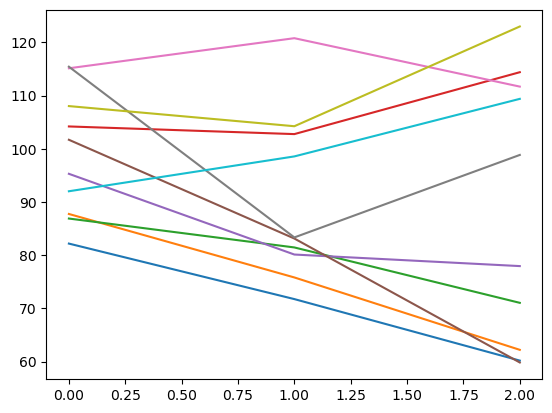

In [85]:
plt.plot(mcBase.St)
plt.show

### Class :: cpuMonteCarlo(MonteCarloBase)
* init: S0, r, sigma, T, nPath, nPeriod, K, opttype
* param:
    * inherited:
        * S0: asset spot price
        * r: risk free rate
        * sigma: asset volacity
        * T: full duration, unit in year base
        * nPath: number of simulation path
        * nPeriod: number of simulation period
    * self owned
        * K: strike price
        * opttype: option direction, 'P' for Put, 'C' for Call
        * dt: need it for option pricing
        * St: simulated St from MonteCarloBase
        * Z: Z matrix from MonteCarloBase
* method:
    * inherited:
        * getZ: get np.array of normal random sequence for GBM
        * getSt: get np.array of fully simulated St trajectories
    * self owned
        * getEuroOption()        # use St, as validation with gpu version
        * getPsoAmerOption(particle)

In [11]:
# Monte Carlo Simulation for American Put Option Pricing
class cpuMonteCarlo(MonteCarloBase):
    def __init__(self, S0, r, sigma, T, nPath, nPeriod, K, opttype):
        super().__init__(S0, r, sigma, T, nPath, nPeriod)
        # initialize parameters
        self.K = np.float32(K)               # strike price
        self.opttype = opttype               # option type 'C' for Call or 'P' for Put
        self.dt = T / nPeriod

    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)
    
    # Monte Carlo European option - CPU
    def getEuroOption(self):
        opt = None
        
        if self.opttype=='C':  opt = -1
        elif self.opttype=='P':  opt = 1
        
#         ts = time.time()
        C_hat_Euro = (np.exp(-self.r*self.T) * np.maximum(0, (self.K - self.St[-1])*opt) ).mean()
#         print('numpy getEuroOption {} ms'.format( (time.time() - ts)*1e3) )
        
        return C_hat_Euro

    # Monte Carlo pso American option - CPU: take one particle each time and loop thru PSO
    def getPsoAmerOption(self, in_particle):
        # add time zero, for cpu version only
        St_full = np.concatenate( (np.full(shape=(1, self.nPath), fill_value=self.S0), self.St) , axis=0)
        particle = np.concatenate(([self.S0], in_particle))

        # determine exercise boundary
        boundaryIdx = np.argmax(St_full < particle[:, None], axis=0)
        boundaryIdx[boundaryIdx==0] = self.nPeriod

        # determine exercise prices
        exerciseSt = St_full[boundaryIdx, np.arange(len(boundaryIdx))] 

        # calculate option price C_hat
        opt = None    
        if self.opttype=='C':  opt = -1
        elif self.opttype=='P':  opt = 1
         
        C_hat = (np.exp(-self.r * boundaryIdx * self.dt) * np.maximum(0, (self.K - exerciseSt)*opt) ).mean()

        return C_hat 

In [12]:
# S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish = 100.0, 0.03, 0.3, 1.0, 20000, 200, 100.0, 'P', 500
pso = np.random.uniform(size=(nPeriod, nFish)).astype(np.float32) * 100

In [13]:
cpuMC = cpuMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype)

In [14]:
ts = time.time()
cpuEuroOpt = cpuMC.getEuroOption()
elapse = time.time() - ts
cpuEuroOpt, 'wall time {} ms'.format(elapse*1e3)

(10.327894, 'wall time 1.38092041015625 ms')

In [15]:
fitFunc_vectorized = np.vectorize(cpuMC.getPsoAmerOption, signature='(n)->()')
ts = time.time()
costs = fitFunc_vectorized(pso.T).astype(np.float32)
elapse = time.time() - ts
np.argmax(costs), 'wall time {} ms'.format(elapse*1e3), #costs

(379, 'wall time 3418.934106826782 ms')

### Class :: gpuMonteCarlo(MonteCarloBase)
* init: S0, r, sigma, T, nPath, nPeriod, K, opttype
* param:
    * inherited:
        * S0: asset spot price
        * r: risk free rate
        * sigma: asset volacity
        * T: full duration, unit in year base
        * nPath: number of simulation path
        * nPeriod: number of simulation period
    * self owned
        * K: strike price
        * opttype: option direction, 'P' for Put, 'C' for Call
        * dt: need it for option pricing
        * St: simulated St from MonteCarloBase
        * Z: Z matrix from MonteCarloBase
* method:
    * inherited:
        * getZ: get np.array of normal random sequence for GBM
        * getSt: get np.array of fully simulated St trajectories
    * self owned
        * getEuroOption()     # use St, as validation with gpu version
        * getPsoAmerOption(pso_buffer, costs_buffer)
        * cleanUp()           # release all memory objects

In [16]:
# Monte Carlo Simulation for American Put Option Pricing
class gpuMonteCarlo(MonteCarloBase):
    def __init__(self, S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish):
        super().__init__(S0, r, sigma, T, nPath, nPeriod)
        # initialize parameters
        self.K = np.float32(K)               # strike price
        self.opttype = opttype   # option type 'C' for Call or 'P' for Put
        self.dt = T / nPeriod
        self.nFish = nFish
        
        # prepare kernel, buffer
        prog = cl.Program(context, knl_source_mc%(nPath, nPeriod)).build()
        self.knl_getEuroOption = cl.Kernel(prog, 'getEuroOption')
        self.knl_psoAmerOption_gb = cl.Kernel(prog, 'psoAmerOption_gb')
        
        self.Z_d = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=self.Z)
        self.St_d = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=self.St)
        
        # array and memory objects for getPsoAmerOption()
        self.boundary_idx = np.zeros(shape=(self.nPath, self.nFish), dtype=np.int32)
        self.exercise = np.zeros(shape=(self.nPath, self.nFish), dtype=np.float32)
        self.boundary_idx_d = cl.Buffer(context, cl.mem_flags.READ_WRITE | cl.mem_flags.COPY_HOST_PTR, hostbuf=self.boundary_idx)
        self.exercise_d = cl.Buffer(context, cl.mem_flags.READ_WRITE | cl.mem_flags.COPY_HOST_PTR, hostbuf=self.exercise)

    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)
    
    # Monte Carlo European option - GPU
    def getEuroOption(self):
        opt = None
        if self.opttype=='C':  opt = -1
        elif self.opttype=='P':  opt = 1
            
        # prepare result array, length of nPath for kernel threads
        results = np.empty(self.nPath, dtype=np.float32)  # length of npath
        results_d = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, size=results.nbytes)
            
        self.knl_getEuroOption.set_args(self.Z_d, np.float32(self.S0), np.float32(self.K), 
                                  np.float32(self.r), np.float32(self.sigma), 
                                  np.float32(self.T), np.int8(opt), results_d)
        
        # run kernel
        global_size = (self.nPath, )
        local_size = None
        evt = cl.enqueue_nd_range_kernel(gpu_queue, self.knl_getEuroOption, global_size, local_size)
#         evt.wait()
#         print('knl_getEuroOption {} ms'.format( (evt.profile.end - evt.profile.start)*1e-6) )
        
        cl.enqueue_copy(gpu_queue, results, results_d, wait_for=[evt])
        gpu_queue.finish()    # <------- sychrnozation
        
        C_hat_Euro = results.mean()
        
        results_d.release()
        
        return C_hat_Euro

    # Monte Carlo pso American option - GPU: take the whole PSO and process once
    def getPsoAmerOption(self, pso_buffer, costs_buffer):
        opt = None
        if self.opttype=='C':  opt = -1
        elif self.opttype=='P':  opt = 1

        self.knl_psoAmerOption_gb.set_args(self.St_d, pso_buffer, costs_buffer, 
                                           self.boundary_idx_d, self.exercise_d, 
                                           np.float32(self.r), np.float32(self.T), np.float32(self.K), np.int8(opt))

        # execute kernel
        global_size = (self.nFish, )
        local_size = None
        evt = cl.enqueue_nd_range_kernel(gpu_queue, self.knl_psoAmerOption_gb, global_size, local_size)
#         evt.wait()
#         print('knl_psoAmerOption_gb: {} ms'.format((evt.profile.end - evt.profile.start)*1e-6))
        
#         # if need to check result, otherwise return 0, costs_buffer already updated
#         costs_gb = np.empty(self.nFish, dtype=np.float32)
#         cl.enqueue_copy(gpu_queue, costs_gb, costs_buffer).wait()

        gpu_queue.finish()    # <------- sychrnozation

        return #costs_buffer

    def cleanUp(self):
        self.Z_d.release()
        self.St_d.release()
        self.boundary_idx_d.release()
        self.exercise_d.release()
        return 

In [17]:
gpuMC = gpuMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish)


In [18]:
ts = time.time()
gpuEuroOpt = gpuMC.getEuroOption()
elapse = time.time() - ts
gpuEuroOpt, 'wall time {} ms'.format(elapse*1e3), 'is equal cpuEuroOpt: {}'.format((cpuEuroOpt-gpuEuroOpt).sum()<1e-5)


(10.327894, 'wall time 17.2269344329834 ms', 'is equal cpuEuroOpt: True')

In [19]:
costs = np.zeros(nFish, dtype=np.float32)
pso_buffer = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=pso)
costs_buffer = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, size=costs.nbytes)
# costs_h_ptr,_= cl.enqueue_map_buffer(gpu_queue, costs_buffer, cl.map_flags.READ, 0, costs.shape, costs.dtype)
ts = time.time()
gpuMC.getPsoAmerOption(pso_buffer, costs_buffer)
cl.enqueue_copy(gpu_queue, costs, costs_buffer).wait()
elapse = time.time() - ts
np.argmax(costs), 'wall time {} ms'.format(elapse*1e3), #costs

(379, 'wall time 1056.6401481628418 ms')

In [20]:
gpuMC.cleanUp()

#### PSO Algorithm

PSO algorithm is defined as follow. For $i=1,···,n$ particles, and each particle has $d=1,···,m$ dimentions, we have <p>
    
$$
velocity: \,\,\,\, \vec{v}_{i,j}(t) = w·\vec{v}_{i,j}(t) + c_1r_1(\vec{p}_{i,j}(t)-\vec{x}_{i,j}(t)) + c_2r_2(\vec{g}(t)-\vec{x}_{i,j}(t)) \tag{eq.1} 
$$<p>
$$
position: \,\,\,\, \vec{x}_{i,j}(t) = \vec{x}_{i,j}(t) + \vec{v}_{i,j}(t) \tag{eq.2}
$$<p>

where $w \in[0.9, 0.4]; \,\,\,\, c_1, c_2=2$ 

### Class::cpuPSO
* init: nFish, nDim, iterMax, fitFuc
* param:
    * nFish: number of particles
    * nDim: number of dimentions
    * iterMax: number of iterations, with exit criteria
    * fitFuc: fitness/cost function
    * w: const
    * c1: const
    * c2: const
    * position: position matrix                  # initial on host and buffer on device
    * velocity: velocity matrix                  # initial on host and buffer on device 
    * costs: nFish vector of fitness/costs       # buffer on device, map to host to update pbest_costs: np.less
    * pbest_costs: nFish vector of best costs    # on host
    * pbest_pos: particle best positions         # buffer on device, map to host to update gbest_pos: np.argmin
    * gbest_cost: max(pbest_costs)               # float on host
    * gbest_pos: position at index of gbest_cost # on host
    * BestCosts: list of historical gbest_cost     # on host
* method:
    * searchGrid()     # pso move to update velocity and position
    * solver()         # main loop of the algorithm

In [21]:
class cpuPSO:
    # const
    __w = 0.5
    __c1 = 0.5
    __c2 = 0.5
    __criteria = 1e-6
    # class initialization
    def __init__(self, nDim, nFish, iterMax, fitFunc, pos_init, vel_init, r1, r2):
        # initial const
        self.nFish = nFish
        self.nDim = nDim
        self.iterMax = iterMax
        self.fitFunc_vectorized = np.vectorize(fitFunc, signature='(n)->()')
        print('Fitness:', fitFunc)
        
        # init swarm particles positions & velocity    (nDim, nFish)
#         self.position = np.random.uniform(size=(self.nDim, self.nFish)).astype(np.float32) * 100
#         self.velocity = np.random.uniform(size=(self.nDim, self.nFish)).astype(np.float32) * 5
        self.position = pos_init.copy()
        self.velocity = vel_init.copy()
        ####>>>>>>>>
        self.r1 = r1
        self.r2 = r2

        # init particles costs          (nFish,)
        self.costs = self.fitFunc_vectorized( np.transpose(self.position) ).astype(np.float32)
#         print('>>',self.costs)
        
        # init personal best (position & cost)
        self.pbest_costs = self.costs.copy()     # (nFish,) 
        self.pbest_pos = self.position.copy()    # (nDim, nFish) each particle has its persional best pos by dimension
        
        # init global best (position & cost)       
        gid = np.argmax(self.pbest_costs)  # find index for global optimal 
        self.gbest_cost = self.pbest_costs[gid]   # np.float32
        self.gbest_pos = self.pbest_pos[:,gid]#.reshape(self.nDim, 1)   # (nDim, 1) reshape to col vector
        
        # create array best global cost storage for each iteration
        self.BestCosts = np.array([])
        
        print('Pure CPU PSO instance ready...')

    # use CPU to update moves
    def searchGrid(self):

#         r1 = np.random.uniform(size=(self.nDim, self.nFish)).astype(np.float32)
#         r2 = np.random.uniform(size=(self.nDim, self.nFish)).astype(np.float32)
        
#         ts = time.time()
        # vectorization  
        self.velocity = self.__w * self.velocity + self.__c1*self.r1*(self.pbest_pos - self.position) + \
                    self.__c2*self.r2*(self.gbest_pos.reshape(self.nDim, 1) - self.position)
#         self.velocity = self.__w * self.velocity + self.__c1*r1*(self.pbest_pos - self.position) + \
#                     self.__c2*r2*(self.gbest_pos.reshape(self.nDim, 1) - self.position)
#         out_v = out_v.clip(vMin, vMax)       # bound velocity
        self.position = self.velocity + self.position
#         out_p = out_p.clip(pMin, pMax)       # bound position
#         print('numpy searchGrid {} ms'.format((time.time()-ts)*1e3))
    
#         # for loop
#         for i in range(self.nFish):   # each col presents one fish
#             self.velocity[:,i] = self.__w * self.velocity[:,i] \
#                     + self.__c1 * self.r1[:,i] * (self.pbest_pos[:,i] - self.position[:,i]) \
#                     + self.__c2 * self.r2[:,i] * (self.gbest_pos - self.position[:,i])
#             self.position[:,i] = self.position[:,i] + self.velocity[:,i]

        return 

    
    # PSO algo core
    def solver(self):
        print('  Solver job started')
        ts = time.time()
        for i in range(self.iterMax):         # loop of iterations
#         while True:

            # 1. particle move                          
            self.searchGrid()

            # 2. recalculate fitness/cost - to be implemented on GPU
            self.costs = self.fitFunc_vectorized( np.transpose(self.position) ).astype(np.float32)

            # 3. update pbest
            mask = np.greater(self.costs, self.pbest_costs)    # numpy vectorized comparison
            self.pbest_costs[mask] = self.costs[mask]
            self.pbest_pos[:,mask] = self.position[:,mask]
            
            # 4. update gbest        
            gid = np.argmax(self.pbest_costs)
            if self.pbest_costs[gid] > self.gbest_cost:  # compare with global best
                self.gbest_cost = self.pbest_costs[gid]
                self.gbest_pos = self.pbest_pos[:,gid]#.reshape(self.nDim, 1)   # (nDim, 1) reshape to col vector
                
            # 5. record global best cost for current iteration
            self.BestCosts = np.concatenate( (self.BestCosts, [self.gbest_cost]) )
    
            # 6. The computation stops when the improvement of the value is less than criteria
            if len(self.BestCosts) > 2 and abs(self.BestCosts[-1] - self.BestCosts[-2]) < self.__criteria:
                break
        
        print('  Solver job done in {} s'.format(round(time.time()-ts, 6)))
        return 
    
    # plot result
    def plot(self):
        plt.semilogy(self.BestCosts)
        plt.yscale('symlog')
        plt.ylabel('Fitness/Costs')
        plt.xlabel('# of iterations')
        plt.title('Global Best Cost Curve')
        print('gBest fitness value =', self.BestCosts[-1])
        print('gBest position:\n', self.gbest_pos.ravel())

In [55]:
S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish = 100.0, 0.03, 0.3, 1.0, 20000, 200, 100.0, 'P', 500
nDim, iterMax = nPeriod, 30
position_init = np.random.uniform(size=(nDim, nFish)).astype(np.float32) * 100
velocity_init = np.random.uniform(size=(nDim, nFish)).astype(np.float32) * 5

r1 = np.random.uniform(size=(nDim, nFish)).astype(np.float32)
r2 = np.random.uniform(size=(nDim, nFish)).astype(np.float32)

In [23]:
cpuMC = cpuMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype)
cpuPso = cpuPSO(nPeriod, nFish, iterMax, cpuMC.getPsoAmerOption, position_init, velocity_init, r1, r2)
# cpuPso.position, cpuPso.costs, cpuPso.pbest_costs, cpuPso.gbest_cost

Fitness: <bound method cpuMonteCarlo.getPsoAmerOption of <__main__.cpuMonteCarlo object at 0x137d83650>>
Pure CPU PSO instance ready...


In [24]:
# cpuPso.position, cpuPso.costs, cpuPso.pbest_pos, cpuPso.gbest_pos, cpuPso.velocity

In [25]:
# cpuPso.searchGrid()
# cpuPso.position, cpuPso.costs, cpuPso.pbest_pos, cpuPso.gbest_pos

In [26]:
cpuPso.solver()

  Solver job started
  Solver job done in 10.103627 s


PSO_CPU iteration: 3 [ 9.97867393 10.47971344 10.47971344]
PSO_CPU optimal price: 10.479713


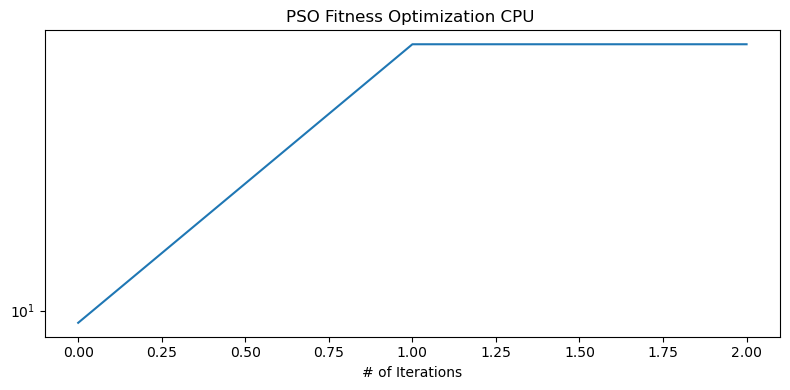

In [27]:
print('PSO_CPU iteration:',len(cpuPso.BestCosts), cpuPso.BestCosts)
print('PSO_CPU optimal price:', cpuPso.gbest_cost)

fig = plt.figure(figsize=(8,4))

plt.semilogy(cpuPso.BestCosts)
plt.title('PSO Fitness Optimization CPU ')
plt.xlabel('# of Iterations')
plt.yscale('symlog')
plt.tight_layout()
plt.show()

### Class::gpuPSO
* init: nFish, nDim, iterMax, fitFuc
* param:
    * nFish: number of particles
    * nDim: number of dimentions
    * iterMax: number of iterations, with exit criteria
    * fitFuc: fitness/cost function
    * w: const
    * c1: const
    * c2: const
    * pos_d: position matrix                     || buffer on device
    * pos_h_prt                                  || map to host to update pbest_pos
    * vel_d: velocity matrix                     || buffer on device 
    * costs_d: nFish vector of fitness/costs     || buffer on device
    * costs_h_ptr                                || map to host to update pbest_costs: np.less
    * pbest_costs: nFish vector of best costs    || on host
    * pbest_pos_d: particle best positions       || buffer on device
    * pbest_pos_h_prt                            || map to host to update gbest_pos: np.argmin
    * gbest_cost: max(pbest_costs_h_ptr)         || float on host
    * gbest_pos_d: position at gbest_cost[gid]   || buffer on device
    * gbest_pos_h_ptr                            || map to host to 
    * BestCosts: array of historical gbest_cost  || on host
    * 
* method:
    * searchGrid()     || pso move to update velocity and position
    * solver()         || main loop of the algorithm
    * cleanUp()        || release all memory objects, REMEMBER to call gpuMC.cleanup as well

In [53]:
class gpuPSO:
    # const
    __w = 0.5
    __c1 = 0.5
    __c2 = 0.5
    __criteria = 1e-6
    # class initialization
    def __init__(self, nDim, nFish, iterMax, fitFunc, pos_init, vel_init, r1, r2):
        # initial const
        self.nFish = nFish
        self.nDim = nDim
        self.iterMax = iterMax
        self.fitFunc = fitFunc
        print('Fitness:',fitFunc)
        
        # init swarm particles positions & velocity    (nDim, nFish)
#         self.position = np.random.uniform(size=(self.nDim, self.nFish)).astype(np.float32) * 100
#         self.velocity = np.random.uniform(size=(self.nDim, self.nFish)).astype(np.float32) * 5
        self.position = pos_init.copy()
        self.velocity = vel_init.copy()
        self.pos_d = cl.Buffer(context, cl.mem_flags.READ_WRITE | cl.mem_flags.COPY_HOST_PTR, hostbuf=self.position)
        self.vel_d = cl.Buffer(context, cl.mem_flags.READ_WRITE | cl.mem_flags.COPY_HOST_PTR, hostbuf=self.velocity)
#         self.pos_h_ptr, _ = cl.enqueue_map_buffer(gpu_queue, self.pos_d, cl.map_flags.READ, 0, 
#                                                   pos_init.shape, pos_init.dtype)
#         self.vel_h_ptr, _ = cl.enqueue_map_buffer(gpu_queue, self.vel_d, cl.map_flags.READ, 0, 
#                                                   vel_init.shape, vel_init.dtype)
        
        ########>>>>>>
        self.r1 = r1
        self.r2 = r2
        self.r1_d = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.USE_HOST_PTR, hostbuf=self.r1)
        self.r2_d = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.USE_HOST_PTR, hostbuf=self.r2)
#         print('--->',self.pos_h_ptr)
        
        # init particles costs          (nFish,)
        float32_bytes = np.dtype(np.float32).itemsize
        self.costs = np.zeros((nFish,), dtype=np.float32)
        self.costs_d = cl.Buffer(context, cl.mem_flags.READ_WRITE | cl.mem_flags.ALLOC_HOST_PTR, size=self.costs.nbytes)
        self.fitFunc(self.pos_d, self.costs_d)

        cl.enqueue_copy(gpu_queue, self.costs, self.costs_d)   # copy back costs
        gpu_queue.finish()    # <------- sychrnozation

        
        # init personal best (costs & position)
        self.pbest_costs = self.costs.copy()     # (nFish,)      
        self.pbest_pos = self.position.copy()    # (nDim, nFish) each particle has its persional best pos by dimension
        self.pbest_pos_d = cl.Buffer(context, cl.mem_flags.READ_WRITE | cl.mem_flags.COPY_HOST_PTR, hostbuf=self.pbest_pos)  
        
        # init global best (costs & position)      
        gid = np.argmax(self.pbest_costs)  # find index for global optimal 
        self.gbest_cost = self.pbest_costs[gid]   # np.float32
        
        self.gbest_pos = self.pbest_pos[:, gid].copy()#.reshape(self.nDim, 1)   # (nDim, ) reshape to col vector
        self.gbest_pos_d = cl.Buffer(context, cl.mem_flags.READ_WRITE | cl.mem_flags.COPY_HOST_PTR, hostbuf=self.gbest_pos)
        
        # create array best global cost storage for each iteration
        self.BestCosts = np.array([])
        
        # prepare kernel, buffer
        prog = cl.Program(context, knl_source_pso%(self.nDim)).build()
        self.knl_searchGrid = cl.Kernel(prog, 'searchGrid')
        
        print(deviceName, 'PSO instance ready...')

     # use GPU to update moves
    def searchGrid(self):
        # generate r1 r2
#         r1 = np.random.uniform(size=(self.nDim, self.nFish)).astype(np.float32)
#         r2 = np.random.uniform(size=(self.nDim, self.nFish)).astype(np.float32)
#         r1_d = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.USE_HOST_PTR, hostbuf=r1)
#         r2_d = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.USE_HOST_PTR, hostbuf=r2)
              
            
        # set kernel arguments
        self.knl_searchGrid.set_args(self.pos_d, self.vel_d, self.pbest_pos_d, self.gbest_pos_d, 
                                     self.r1_d, self.r2_d, 
                                     np.float32(self.__w), np.float32(self.__c1), np.float32(self.__c2))
        
#         self.knl_searchGrid.set_args(self.pos_d, self.vel_d, self.pbest_pos_d, self.gbest_pos_d, 
#                                      r1_d, r2_d, 
#                                      np.float32(self.__w), np.float32(self.__c1), np.float32(self.__c2))
        # run kernel
        global_size = (self.nFish, )
        local_size = None
        evt = cl.enqueue_nd_range_kernel(gpu_queue, self.knl_searchGrid, global_size, local_size)
#         evt.wait()
        gpu_queue.finish()
#         print('knl_searchGrid {} ms'.format( (evt.profile.end - evt.profile.start)*1e-6) )
        
    
# #         # if need to check result, otherwise return 0, pos_d already updated
#         new_pos = np.empty_like(self.pos)
#         new_vel = np.empty_like(self.vel)
#         cl.enqueue_copy(gpu_queue, new_pos, self.pos_d).wait()
#         cl.enqueue_copy(gpu_queue, new_vel, self.vel_d).wait()
#         print('new_pos\n', new_pos)
#         print('new_vel\n', new_vel)
                        
#         r1_d.release()
#         r2_d.release()
                                    
        return 
            
    # PSO algo core
    def solver(self):
        print('  Solver job started')
        ts = time.time()

        for i in range(self.iterMax):         # loop of iterations
#         while True:
            
            # 1. particle move            
            self.searchGrid()
            cl.enqueue_copy(gpu_queue, self.position, self.pos_d).wait()   # read back new position
            gpu_queue.finish()    # <------- sychrnozation

            # 2. recalculate fitness/cost - to be implemented on GPU
            self.fitFunc(self.pos_d, self.costs_d)
            cl.enqueue_copy(gpu_queue, self.costs, self.costs_d).wait()   # read back new costs
            gpu_queue.finish()    # <------- sychrnozation

            # 3. update pbest
            mask = np.greater(self.costs, self.pbest_costs)    # numpy vectorized comparison
            self.pbest_costs[mask] = self.costs[mask]
            self.pbest_pos[:,mask] = self.position[:,mask]
            cl.enqueue_copy(gpu_queue, self.pbest_pos_d, self.pbest_pos).wait()   # write to device new pbest_pos
            gpu_queue.finish()    # <------- sychrnozation
            
            # 4. update gbest        
            gid = np.argmax(self.pbest_costs)            
            if self.pbest_costs[gid] > self.gbest_cost:  # compare with global best
                self.gbest_cost = self.pbest_costs[gid]
                self.gbest_pos = self.pbest_pos[:,gid].copy() #.reshape(self.nDim, 1)   # (nDim, 1) reshape to col vector
                cl.enqueue_copy(gpu_queue, self.gbest_pos_d, self.gbest_pos).wait()   # write to device new gbest_pos
                gpu_queue.finish()    # <------- sychrnozation
    
            # 5. record global best cost for current iteration
            self.BestCosts = np.concatenate( (self.BestCosts, [self.gbest_cost]) )
    
            # 6. The computation stops when the improvement of the value is less than criteria
            if len(self.BestCosts) > 2 and abs(self.BestCosts[-1] - self.BestCosts[-2]) < self.__criteria:
                break
        
        print('  Solver job done in {} s'.format(round(time.time()-ts, 6)))
        return 

    # plot result
    def plot(self):
        plt.semilogy(self.BestCosts)
        plt.yscale('symlog')
        plt.ylabel('Fitness/Costs')
        plt.xlabel('# of iterations')
        plt.title('Global Best Cost Curve')
        print('gBest fitness value =', self.BestCosts[-1])
#         print('gBest position:\n', self.gbest_pos_h_ptr.ravel())
        
    def cleanUp(self):
        self.pos_d.release()
        self.vel_d.release()
        self.costs_d.release()
        self.pbest_pos_d.release()
        self.gbest_pos_d.release()
        return

In [56]:
gpuMC = gpuMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish)
gpuPso = gpuPSO(nPeriod, nFish, iterMax, gpuMC.getPsoAmerOption, position_init, velocity_init, r1, r2)
# gpuPso.pos_h_ptr, gpuPso.costs_h_ptr, gpuPso.pbest_costs, gpuPso.gbest_cost


Fitness: <bound method gpuMonteCarlo.getPsoAmerOption of <__main__.gpuMonteCarlo object at 0x17753b850>>
OpenCL_GPU PSO instance ready...


In [57]:
# gpuPso.pos, gpuPso.costs, gpuPso.pbest_pos, gpuPso.gbest_pos, gpuPso.vel

In [58]:
# gpuPso.searchGrid()
# cl.enqueue_copy(gpu_queue, gpuPso.pos, gpuPso.pos_d)
# gpuPso.pos, gpuPso.costs, gpuPso.pbest_pos, gpuPso.gbest_pos
# (gpuPso.pos - cpuPso.position).sum() <1e-2

In [59]:
gpuPso.solver()

  Solver job started
  Solver job done in 8.931838 s


PSO_GPU iteration: 12 [ 9.8494463  10.30739021 10.40405083 10.49806404 10.53656578 10.55749702
 10.57382011 10.58754921 10.58785915 10.59171104 10.59882069 10.59882069]
PSO_GPU optimal price: 10.598821


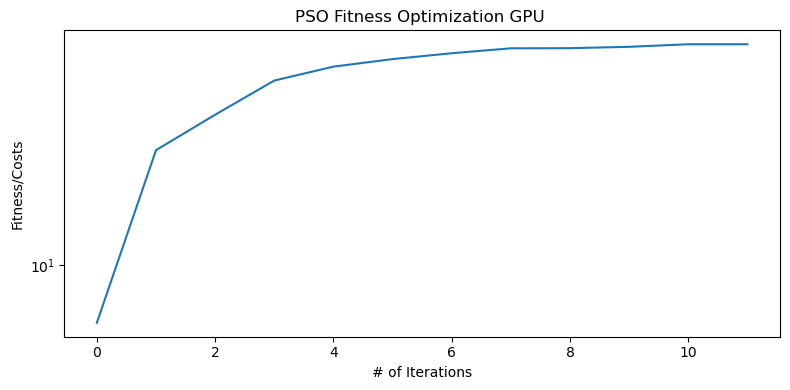

In [60]:
print('PSO_GPU iteration:',len(gpuPso.BestCosts), gpuPso.BestCosts)
print('PSO_GPU optimal price:', gpuPso.gbest_cost)

fig = plt.figure(figsize=(8,4))

plt.semilogy(gpuPso.BestCosts)
plt.title('PSO Fitness Optimization GPU ')
plt.xlabel('# of Iterations')
plt.yscale('symlog')
plt.ylabel('Fitness/Costs')
plt.tight_layout()
plt.show()

In [61]:
gpuMC.cleanUp()
gpuPso.cleanUp()

### Benchmark
* Black Scholes
* Binomial European Option
* Binomial American Option
* Monte Carlo European Option - CPU version
* Monte Carlo European Option - GPU version

#### Black Scholes
$C_0 = S_0 \cdot N(d1) - e^{-rt}K \cdot N(d2)$<p>
$P_0 = C_0 - S_0 + e^{-rt}K$, or, $P_0 = e^{-rt}K \cdot N(-d2) - S_0 \cdot N(-d1)$<p>
where:<p>
$d1 = \frac{ln(\frac{S_0}{K}) + (r+\frac{\sigma ^2}{2})t}{\sigma \sqrt t}$, and, $d2 = d1 - \sigma \sqrt t$

In [35]:
# Black-Scholes
from scipy.stats import norm

def blackScholes(S0, K, r, sigma, T, opttype='P'):
    d1 = (np.log(S0/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    call_price = S0*norm.cdf(d1) - np.exp(-r*T)*K*norm.cdf(d2)
    put_price = call_price - S0 + np.exp(-r*T)*K
    
    if opttype == 'C':
#         price = S0*norm.cdf(d1) - np.exp(-r*T)*K*norm.cdf(d2)
        price = call_price
    elif opttype == 'P':
#         price = np.exp(-r*T)*K*norm.cdf(-d2) - S0*norm.cdf(-d1) 
        price = put_price
    return price

print('Black-Scholes price:', blackScholes(S0, K, r, sigma, T, opttype))

Black-Scholes price: 10.327861752731735


#### Binomial Tree Representation
Stock tree can be represented using nodes (i,j) and initial stock price $S_0$ <p>
$S_{i,j}=S_0u^jd^{i-j}$, u is the price up move, and d is price down move<p>
$C_{i,j}$ represents contract price at each node (i,j). Where $C_{N,j}$ represents final payoff function that we can define. <p>
For a **European Call**, so $C_{N,j}=max(S_{N,j}-K, 0)$, for **Put**, $C_{N,j}=max(K-S_{N,j},0)$<p>

#### Binomial Lattice with Cox, Ross, & Rubinstein (CRR) formulae (following diagram)
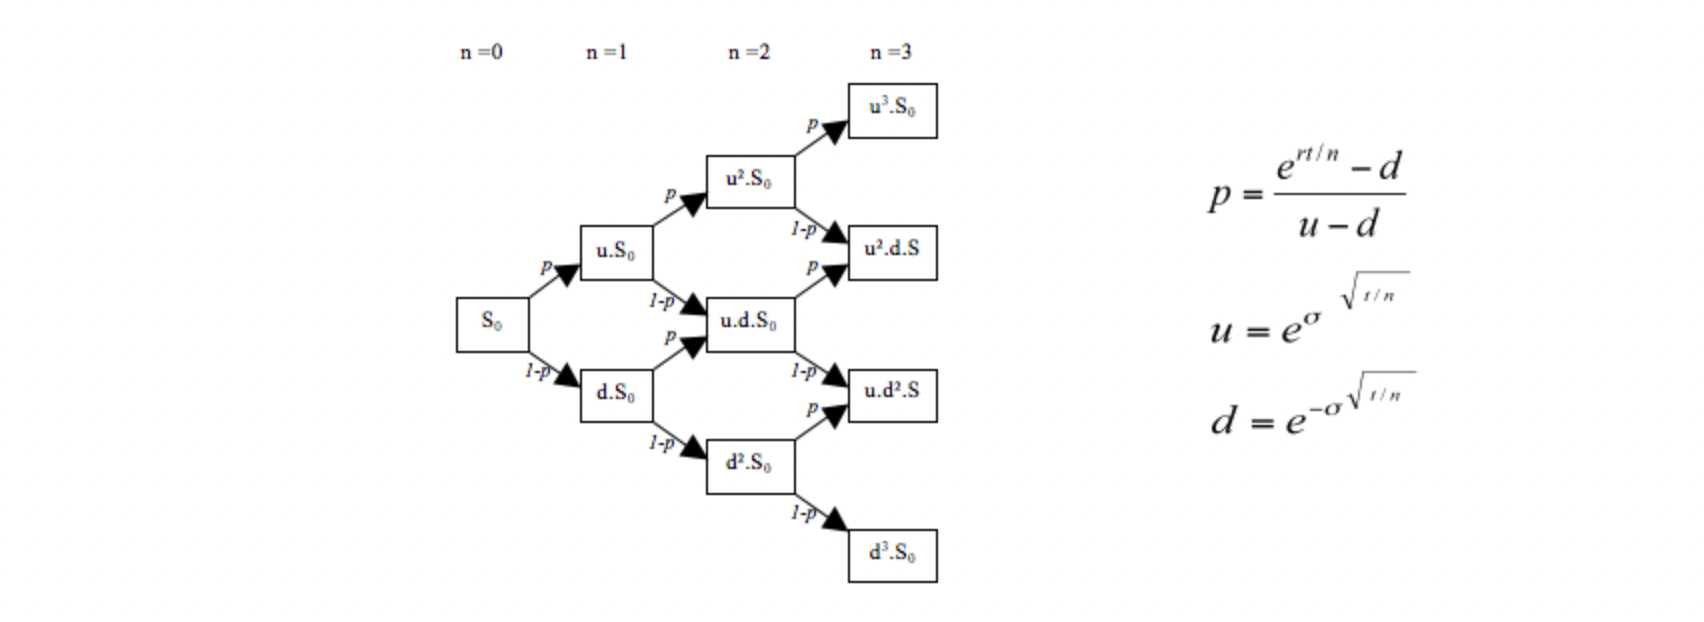

In [36]:
# European stype via binomial tree
def binomialEuroOption(S0, K, nPeriod, T, opttype='P'):
    # precompute values
    dt = T / nPeriod                          # delta_t

    # for binomial tree 
    q = 0.0
    u = np.exp(sigma * np.sqrt(dt))           # up-factor in binomial tree
    d = 1/u                                   # down-factor in binomial tree, ensure recombining tree
    p = (np.exp((r - q) * dt) - d) / (u - d)  # probability 
    discount = np.exp(-r * dt)                # discount factor
    
    # initialize stock prices binomial matrix from time zero to maturity
    # number of nodes = N-1+2, indexing start from 0 to N, including N, in total N+1 nodes
    S = S0 * d**(np.arange(nPeriod, -1, -1)) * u**(np.arange(0, nPeriod+1, 1))
        
    # option payoffs at maturity
    if opttype=='P':
        C = np.maximum(0, K - S)
    else:
        C = np.maximum(0, S - K)

    # backward recursion thru the tree
    for i in np.arange(nPeriod-1, -1, -1):
        S = S0 * d**(np.arange(i, -1, -1)) * u**(np.arange(0, i+1, 1)) # np.array 自适应长度

        # 初始 C 为上一层, C[1:]为 up vector, C[:-1]为 down vector, 计算后 vector 长度 -1
        C = discount * ( p * C[1:] + (1-p) * C[:-1] )   
#         if opttype=='P':
#             C = np.maximum(C, K - S)
#         else:
#             C = np.maximum(C, S - K)
            
    return C[0]

print('Binomial European price:', binomialEuroOption(S0, K, nPeriod, T, opttype))

Binomial European price: 10.313117224095244


#### American Option Characteristics
Stock prices at time $i$ and path $j$:<p>
$S_{i,j}=S_0u^jd^{i-j}$

For an American Put Option:<p>
if $T=t_N$ then at the terminal nodes, $C_{N,j}=max(K-S_{N,j}, 0)$<p>
for all other parts of the tree at nodes ($i$,$j$):<p>
* First to calculate the binomial value: $biC_{i-\triangle t, j} = e^{-r\triangle t}\left[pC_{i,j+1} + (1-p)C_{i, j}\right]$, where $e^{-r\triangle t}$ is the continuous discount factor, $p$ is the probability price going up in one period;<p>
* Then to calculate the exercise value: $exC_{i, j} = K - S_{i,j}$ for each node;<p>
* Finally the option price: $C_{i,j} = max(exC_{i, j}, biC_{i,j})$ This is the max of exercised value or the binomial value<p>
* Normally American *Call* option (for an underlying stock that doesn't pay divident and there's no negative interest rate) won't be exercised early before terminal date, simply because exercising means investing in K and losing the interest rate if it were saved in the bank account, and the contiuous value is always larger than the payoff of an early exercised call option. The call option value can be calculated using Black-Sholes formula

In [37]:
# American stype via binomial tree
def binomialAmericanOption(S0, K, nPeriod, T, opttype='P'):
    # precompute values
    dt = T / nPeriod                          # delta_t

    # for binomial tree 
    q = 0.0
    u = np.exp(sigma * np.sqrt(dt))           # up-factor in binomial tree
    d = 1/u                                   # down-factor in binomial tree, ensure recombining tree
    p = (np.exp((r - q) * dt) - d) / (u - d)  # probability 
    discount = np.exp(-r * dt)                # discount factor
    
    # initialize stock prices binomial matrix from time zero to maturity
    # number of nodes = N-1+2, indexing start from 0 to N, including N, in total N+1 nodes
    S = S0 * d**(np.arange(nPeriod, -1, -1)) * u**(np.arange(0, nPeriod+1, 1))
        
    # option payoffs at maturity
    if opttype=='P':
        C = np.maximum(0, K - S)
    else:
        C = np.maximum(0, S - K)

    # backward recursion thru the tree
    for i in np.arange(nPeriod-1, -1, -1):
        S = S0 * d**(np.arange(i, -1, -1)) * u**(np.arange(0, i+1, 1)) # np.array 自适应长度

        # 初始 C 为上一层, C[1:]为 up vector, C[:-1]为 down vector, 计算后 vector 长度 -1
        C = discount * ( p * C[1:] + (1-p) * C[:-1] )   
        if opttype=='P':
            C = np.maximum(C, K - S)
        else:
            C = np.maximum(C, S - K)
            
    return C[0]

print('Binomial American price:', binomialAmericanOption(S0, K, nPeriod, T, opttype))

Binomial American price: 10.600132797709824


#### Monte Carlo European option

$\hat C_0 = \frac{1}{M}\Sigma_{j=1}^M C_j $<p>
where $C_j$ is the payoff on simulated path j and discounted back to current moment, e.g. Put option:<p>
$C_j = e^{-rT} \cdot max(0, K - S_j)$, and $S_j$ is the simulated underlying price at maturity

In [38]:
# Monte Carlo European option cpu
def monteCarloEuroOption_cpu(S0, r, sigma, T, nPath, nPeriod, K, opttype):
    mc = cpuMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype)
    C_hat_Euro = mc.getEuroOption()
    
    return C_hat_Euro

monteCarloEuroOption_cpu(S0, r, sigma, T, nPath, nPeriod, K, opttype)

10.327894

In [39]:
# Monte Carlo European option cpu
def monteCarloEuroOption_gpu(S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish):    
    mc = gpuMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish)
    C_hat_Euro = mc.getEuroOption()
    
    return C_hat_Euro

monteCarloEuroOption_gpu(S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish)

10.327894

### Seeds creening

In [40]:
# # CPU/GPU version of seed screening
# S0, r, sigma, T, nPath, nPeriod, K, opttype = 100.0, 0.03, 0.3, 1.0, 20000, 200, 100.0, 'P'
# benchmark = blackScholes(S0, K, r, sigma, T, opttype)
# print('Black-Scholes benchmark:',benchmark)

# mc = cpuMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype)
# j = 0  # starting index at inner loop
# error = [1e-2, 1e-3, 1e-4, 1e-5] #1e-6
# seed = 0
# print('current seed', mc.getSeed())
# for criteria in error:
#     ts = time.time()
#     for i in range(j, 2**32):
#         seed = i
#         mc.setSeed(seed)
#         C_hat_Euro = mc.getEuroOption()
        
#         if abs(C_hat_Euro - benchmark) < criteria:
#             j = i + 1
#             break
            
#     elapse = round(time.time()-ts, 3)
#     print('Seed found:', seed, '| Computed C_hat_Euro:', C_hat_Euro, 
#           '| difference:',C_hat_Euro - benchmark, '| deviate <', criteria, 'in {}s'.format(elapse))
    
# # save seed to file
# '''
# Black-Scholes benchmark: 10.327861752731735
# Seed found: 10 | Computed C_hat_Euro: 10.327894 | difference: 3.2458083694564266e-05 | deviate < 0.01 in 1.427s
# Seed found: 13 | Computed C_hat_Euro: 10.328727 | difference: 0.0008650157619172205 | deviate < 0.001 in 0.391s
# Seed found: 250 | Computed C_hat_Euro: 10.327925 | difference: 6.297566181956427e-05 | deviate < 0.0001 in 30.774s
# '''

# Main

#### Initialize parameters

In [62]:
S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish = 100.0, 0.03, 0.3, 1.0, 20000, 200, 100.0, 'P', 500
nDim, iterMax = nPeriod, 30
position_init = np.random.uniform(size=(nDim, nFish)).astype(np.float32) * 100
velocity_init = np.random.uniform(size=(nDim, nFish)).astype(np.float32) * 5
r1 = np.random.uniform(size=(nDim, nFish)).astype(np.float32)
r2 = np.random.uniform(size=(nDim, nFish)).astype(np.float32)
print('PSO ready...')

PSO ready...


In [63]:
print('PSO population {}, dimensions {}, iteration {}'.format(nFish, nDim, iterMax)) 
print('Monte Carlo & Binomial {} periods, {} simulation paths'.format(nPeriod, nPath))
print('Spot price ${}, Strike price ${}, Time to maturity {}, Annual return {}%, Annual volatility {}%'.format(
            S0, K, T, r*100., sigma*100.))

PSO population 500, dimensions 200, iteration 30
Monte Carlo & Binomial 200 periods, 20000 simulation paths
Spot price $100.0, Strike price $100.0, Time to maturity 1.0, Annual return 3.0%, Annual volatility 30.0%


##### Option pricing benchmarks with theroies in the literature
* Black-Scholes
* Binomial European Put
* Binomial American Put
* Monte Carlo Euorpean Put

In [64]:
# for K in range(80, 140, 10):
#     print('Strike price K=${}'.format(K))

# for T in np.arange(.25, 1.25, .25):
#     print('Maturity @ T={}'.format(T))

print('Black-Scholes price:', blackScholes(S0, K, r, sigma, T, opttype))
print('Binomial European price:', binomialEuroOption(S0, K, nPeriod, T, opttype))
print('Binomial American price:', binomialAmericanOption(S0, K, nPeriod, T, opttype))
print('Monte Carlo European_CPU price:', monteCarloEuroOption_cpu(S0, r, sigma, T, nPath, nPeriod, K, opttype))
print('Monte Carlo European_GPU price:', monteCarloEuroOption_gpu(S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish))


Black-Scholes price: 10.327861752731735
Binomial European price: 10.313117224095244
Binomial American price: 10.600132797709824
Monte Carlo European_CPU price: 10.327894
Monte Carlo European_GPU price: 10.327894


##### PSO Monte Carlo pricing with different Maturity or Strikes
* pure_CPU 
* OpenCL_CPU
* OpenCL_GPU

In [65]:
# pure_CPU

# for K in range(80, 140, 10):
#     print('Strike price K=${}'.format(K))

for T in np.arange(.25, 1.25, .25):
    print('Maturity @ T={}'.format(T))

    ts = time.time()
    cpuMC = cpuMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype)
    cpuPso = cpuPSO(nDim, nFish, iterMax, cpuMC.getPsoAmerOption, position_init, velocity_init, r1, r2)
    cpuPso.solver()

    elapse = time.time() - ts
    print('pure_CPU done in {} s'.format(round(elapse, 6)) )
    print('PSO_pure_CPU optimal price:', cpuPso.BestCosts[-1])

Maturity @ T=0.25
Fitness: <bound method cpuMonteCarlo.getPsoAmerOption of <__main__.cpuMonteCarlo object at 0x17751c990>>
Pure CPU PSO instance ready...
  Solver job started
  Solver job done in 14.678175 s
pure_CPU done in 18.519708 s
PSO_pure_CPU optimal price: 5.639743804931641
Maturity @ T=0.5
Fitness: <bound method cpuMonteCarlo.getPsoAmerOption of <__main__.cpuMonteCarlo object at 0x15fba9ed0>>
Pure CPU PSO instance ready...
  Solver job started
  Solver job done in 10.660237 s
pure_CPU done in 14.304899 s
PSO_pure_CPU optimal price: 7.753522872924805
Maturity @ T=0.75
Fitness: <bound method cpuMonteCarlo.getPsoAmerOption of <__main__.cpuMonteCarlo object at 0x16ca2e750>>
Pure CPU PSO instance ready...
  Solver job started
  Solver job done in 21.255175 s
pure_CPU done in 24.948933 s
PSO_pure_CPU optimal price: 9.337056159973145
Maturity @ T=1.0
Fitness: <bound method cpuMonteCarlo.getPsoAmerOption of <__main__.cpuMonteCarlo object at 0x15fba9a90>>
Pure CPU PSO instance ready...

In [152]:
# # OpenCL_CPU

# # device = platform.get_devices(cl.device_type.GPU)[0]
# device = platform.get_devices(cl.device_type.CPU)[0]
# print('Initializing opencl context on', cl.device_type.to_string(device.type).rpartition(' ')[2], device.name)
# deviceName = 'OpenCL_' + cl.device_type.to_string(device.type).rpartition(' ')[2]
# print('device name:', deviceName)

# context = cl.Context([device])
# gpu_queue = cl.CommandQueue(context, properties=cl.command_queue_properties.PROFILING_ENABLE)

# # for K in range(80, 140, 10):
# #     print('Strike price K=${}'.format(K))

# for T in np.arange(.25, 1.25, .25):
#     print('Maturity @ T={}'.format(T))

#     ts = time.time()
#     gpuMC = gpuMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish)
#     gpuPso = gpuPSO(nDim, nFish, iterMax, gpuMC.getPsoAmerOption, position_init, velocity_init, r1, r2)
#     gpuPso.solver()

#     elapse = time.time() - ts
#     print('OpenCL_CPU done in {} s'.format(round(elapse, 6)) )
#     print('PSO_OpenCL_CPU optimal price:', gpuPso.BestCosts[-1])

# gpuPso.cleanUp()
# gpuMC.cleanUp()

Initializing opencl context on CPU Apple M1
device name: OpenCL_CPU
Maturity @ T=0.25
Fitness: <bound method gpuMonteCarlo.getPsoAmerOption of <__main__.gpuMonteCarlo object at 0x7f7fb0ebd8b0>>
OpenCL_CPU PSO instance ready...
  Solver job started
  Solver job done in 25.508975 s
OpenCL_CPU done in 31.272938 s
PSO_OpenCL_CPU optimal price: 5.644604682922363
Maturity @ T=0.5
Fitness: <bound method gpuMonteCarlo.getPsoAmerOption of <__main__.gpuMonteCarlo object at 0x7f7fb0ebd730>>
OpenCL_CPU PSO instance ready...
  Solver job started
  Solver job done in 33.056756 s
OpenCL_CPU done in 38.803568 s
PSO_OpenCL_CPU optimal price: 7.788073539733887
Maturity @ T=0.75
Fitness: <bound method gpuMonteCarlo.getPsoAmerOption of <__main__.gpuMonteCarlo object at 0x7f7fb08c72b0>>
OpenCL_CPU PSO instance ready...
  Solver job started
  Solver job done in 22.360819 s
OpenCL_CPU done in 28.0072 s
PSO_OpenCL_CPU optimal price: 9.313067436218262
Maturity @ T=1.0
Fitness: <bound method gpuMonteCarlo.getPs

In [66]:
# OpenCL_GPU

device = platform.get_devices(cl.device_type.GPU)[0]
# device = platform.get_devices(cl.device_type.CPU)[0]
print('Initializing opencl context on', cl.device_type.to_string(device.type).rpartition(' ')[2], device.name)
deviceName = 'OpenCL_' + cl.device_type.to_string(device.type).rpartition(' ')[2]
print('device name:', deviceName)

context = cl.Context([device])
gpu_queue = cl.CommandQueue(context, properties=cl.command_queue_properties.PROFILING_ENABLE)
    
# for K in range(80, 140, 10):
#     print('Strike price K=${}'.format(K))

for T in np.arange(.25, 1.25, .25):
    print('Maturity @ T={}'.format(T))

    ts = time.time()
    gpuMC = gpuMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish)
    gpuPso = gpuPSO(nDim, nFish, iterMax, gpuMC.getPsoAmerOption, position_init, velocity_init, r1, r2)
    gpuPso.solver()

    elapse = time.time() - ts
    print('OpenCL_GPU done in {} s'.format(round(elapse, 6)) )
    print('PSO_OpenCL_GPU optimal price:', gpuPso.BestCosts[-1])

gpuPso.cleanUp()
gpuMC.cleanUp()

Initializing opencl context on GPU Apple M1
device name: OpenCL_GPU
Maturity @ T=0.25
Fitness: <bound method gpuMonteCarlo.getPsoAmerOption of <__main__.gpuMonteCarlo object at 0x15fae58d0>>
OpenCL_GPU PSO instance ready...
  Solver job started
  Solver job done in 2.900721 s
OpenCL_GPU done in 4.101675 s
PSO_OpenCL_GPU optimal price: 5.639737606048584
Maturity @ T=0.5
Fitness: <bound method gpuMonteCarlo.getPsoAmerOption of <__main__.gpuMonteCarlo object at 0x1773989d0>>
OpenCL_GPU PSO instance ready...
  Solver job started
  Solver job done in 2.390363 s
OpenCL_GPU done in 3.612524 s
PSO_OpenCL_GPU optimal price: 7.753525733947754
Maturity @ T=0.75
Fitness: <bound method gpuMonteCarlo.getPsoAmerOption of <__main__.gpuMonteCarlo object at 0x16ca2d110>>
OpenCL_GPU PSO instance ready...
  Solver job started
  Solver job done in 4.606375 s
OpenCL_GPU done in 5.811765 s
PSO_OpenCL_GPU optimal price: 9.33706283569336
Maturity @ T=1.0
Fitness: <bound method gpuMonteCarlo.getPsoAmerOption of

##### pure CPU vs. opencl CPU vs. opencl GPU

In [67]:
# pure CPU
print('Pure CPU >>>')
ts = time.time()
cpuMC = cpuMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype)
pureCpuPso = cpuPSO(nDim, nFish, iterMax, cpuMC.getPsoAmerOption, position_init, velocity_init, r1, r2)
pureCpuPso.solver()
elapse_pureCPU = time.time() - ts

# # OpenCL CPU
# print('\nOpenCL CPU >>>')
# device = platform.get_devices(cl.device_type.CPU)[0]
# print('Initializing opencl context on', device.name, cl.device_type.to_string(device.type).rpartition(' ')[2])
# deviceName = 'OpenCL_' + cl.device_type.to_string(device.type).rpartition(' ')[2]
# print('device name:', deviceName)

# context = cl.Context([device])
# gpu_queue = cl.CommandQueue(context, properties=cl.command_queue_properties.PROFILING_ENABLE)

# ts = time.time()
# gpuMC = gpuMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish)
# openCLCpuPso = gpuPSO(nDim, nFish, iterMax, gpuMC.getPsoAmerOption, position_init, velocity_init, r1, r2)
# openCLCpuPso.solver()
# elapse_openCL_CPU = time.time() - ts

# openCLCpuPso.cleanUp()
# gpuMC.cleanUp()

# OpenCL GPU
print('\nOpenCL GPU >>>')
device = platform.get_devices(cl.device_type.GPU)[0]
print('Initializing opencl context on', device.name, cl.device_type.to_string(device.type).rpartition(' ')[2])
deviceName = 'OpenCL_' + cl.device_type.to_string(device.type).rpartition(' ')[2]
print('device name:', deviceName)

context = cl.Context([device])
gpu_queue = cl.CommandQueue(context, properties=cl.command_queue_properties.PROFILING_ENABLE)

ts = time.time()
gpuMC = gpuMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish)
openCLGpuPso = gpuPSO(nDim, nFish, iterMax, gpuMC.getPsoAmerOption, position_init, velocity_init, r1, r2)
openCLGpuPso.solver()
elapse_openCL_GPU = time.time() - ts

openCLGpuPso.cleanUp()
gpuMC.cleanUp()



Pure CPU >>>
Fitness: <bound method cpuMonteCarlo.getPsoAmerOption of <__main__.cpuMonteCarlo object at 0x1775d4e90>>
Pure CPU PSO instance ready...
  Solver job started
  Solver job done in 35.110515 s

OpenCL GPU >>>
Initializing opencl context on Apple M1 GPU
device name: OpenCL_GPU
Fitness: <bound method gpuMonteCarlo.getPsoAmerOption of <__main__.gpuMonteCarlo object at 0x177545050>>
OpenCL_GPU PSO instance ready...
  Solver job started
  Solver job done in 7.55705 s


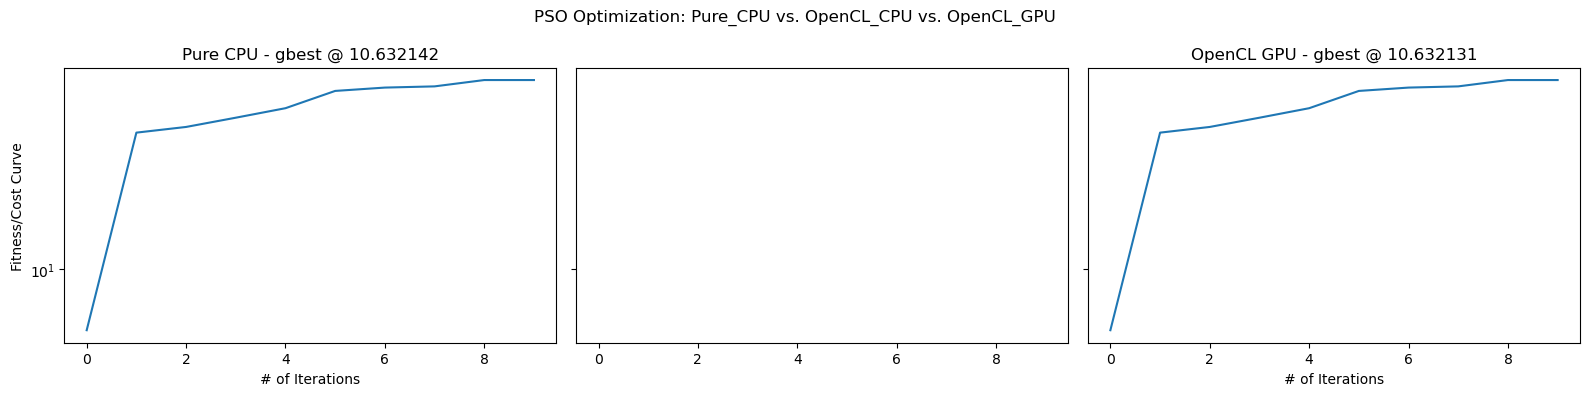

In [68]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16,4))

ax1.semilogy(cpuPso.BestCosts)
ax1.set_title('Pure CPU - gbest @ %f'%(cpuPso.BestCosts[-1]))
ax1.set_ylabel('Fitness/Cost Curve')
ax1.set_xlabel('# of Iterations')

# ax2.semilogy(openCLCpuPso.BestCosts)
# ax2.set_title('OpenCL CPU - gbest @ %f'%(openCLCpuPso.BestCosts[-1]))
# ax2.set_xlabel('# of Iterations')

ax3.semilogy(openCLGpuPso.BestCosts)
ax3.set_title('OpenCL GPU - gbest @ %f'%(openCLGpuPso.BestCosts[-1]))
ax3.set_xlabel('# of Iterations')

# elapse = np.array([elapse_pureCPU, elapse_openCL_CPU, elapse_openCL_GPU])
# labels = ['Pure_CPU', 'OpenCL_CPU', 'OpenCL_GPU']
# ax4.bar(np.arange(len(elapse)), elapse)
# ax4.set_title('Computation Time')
# ax4.set_ylabel('seconds')
# ax4.set_xticks(np.arange(len(elapse)))
# ax4.set_xticklabels(labels)

plt.suptitle('PSO Optimization: Pure_CPU vs. OpenCL_CPU vs. OpenCL_GPU')
# plt.xlabel('# of Iterations')
plt.yscale('symlog')
plt.tight_layout()
plt.show()

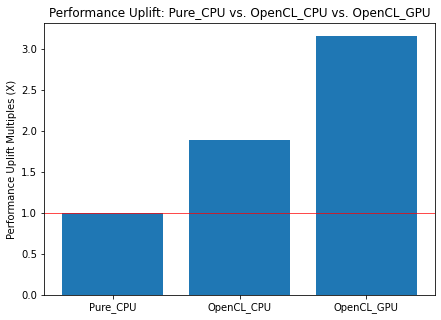

In [81]:
fig, ax = plt.subplots(figsize=(7,5))

elapse = np.array([elapse_pureCPU, elapse_openCL_CPU, elapse_openCL_GPU])
uplift = elapse_pureCPU / elapse
labels = ['Pure_CPU', 'OpenCL_CPU', 'OpenCL_GPU']
ax.bar(np.arange(len(elapse)), uplift,)

ax.set_title('Performance Uplift: Pure_CPU vs. OpenCL_CPU vs. OpenCL_GPU')
ax.set_ylabel('Performance Uplift Multiples (X)')
ax.set_xticks(np.arange(len(elapse)))
ax.set_xticklabels(labels=labels)

plt.axhline(1, c='r', lw=.7) 

plt.show()

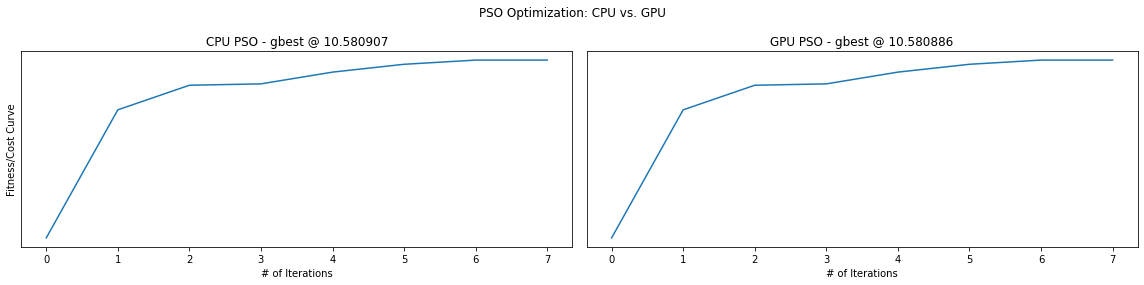

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16,4))

ax1.semilogy(cpuPso.BestCosts)
ax1.set_title('CPU PSO - gbest @ %f'%(cpuPso.BestCosts[-1]))
ax1.set_ylabel('Fitness/Cost Curve')
ax1.set_xlabel('# of Iterations')

ax2.semilogy(openCLCpuPso.BestCosts)
ax2.set_title('GPU PSO - gbest @ %f'%(openCLGpuPso.BestCosts[-1]))
ax2.set_xlabel('# of Iterations')


plt.suptitle('PSO Optimization: CPU vs. GPU')
# plt.xlabel('# of Iterations')
plt.yscale('symlog')
plt.tight_layout()
plt.show()

### Function wise performance comparison
##### fitness function: pso American option

In [44]:
S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish = 100.0, 0.03, 0.3, 1.0, 20000, 200, 100.0, 'P', 500

In [45]:
def measureFitness(min_exp, max_exp, step, S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish):
    cpuMC = cpuMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype)
    gpuMC = gpuMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish)

    kernel_wall_time = []
    copy_time = []
    numpy_time = []
    fish_size = []

    print('St simulated with %d paths and %d periods' % (nPath, nPeriod))
    
    for exponent in range(min_exp, max_exp, step):  # This bit shift << operation does 'two to the exponent' (2^exponent)
        nFish = 1 << exponent            # 相当于 2 ** max_exp
        fish_size.append(nFish)
        print("exponent @ %s with nFish set to %d" %(exponent, nFish))

        # initialize data & memory objects
        pso = np.random.uniform(size=(nPeriod, nFish)).astype(np.float32) * 100
        costs = np.empty(nFish, dtype=np.float32)
        pso_d = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=pso)
        costs_d = cl.Buffer(context, cl.mem_flags.WRITE_ONLY | cl.mem_flags.ALLOC_HOST_PTR, size=costs.nbytes)
        
        # -------> run kernel
        ts = time.time() 
        gpuMC.getPsoAmerOption(pso_d, costs_d)
        gpu_queue.finish()
        evt_copy = cl.enqueue_copy(gpu_queue, costs, costs_d)
        gpu_queue.finish()
        
        walltime = (time.time() - ts)*1e3
        copytime = (evt_copy.profile.end - evt_copy.profile.start)*1e-6

        copy_time.append(round(copytime, 4))
        kernel_wall_time.append(round(walltime, 4))
        
        # -------> run benchmark
        fitFunc = np.vectorize(cpuMC.getPsoAmerOption, signature='(n)->()')
        ts = time.time()
        costs_valid = fitFunc(pso.T).astype(np.float32)
        numpytime = (time.time() - ts)*1e3
        numpy_time.append(round(numpytime, 4))
        
    # cleanup device memory
    gpuMC.cleanUp()
    
    return copy_time, kernel_wall_time, numpy_time, fish_size


In [46]:
min_exp, max_exp, step = 2, 17, 2
copy_time_fit, kernel_wall_time_fit, numpy_time_fit, fish_size =  measureFitness(min_exp, max_exp, step, S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish)


St simulated with 20000 paths and 200 periods
exponent @ 2 with nFish set to 4
exponent @ 4 with nFish set to 16
exponent @ 6 with nFish set to 64
exponent @ 8 with nFish set to 256
exponent @ 10 with nFish set to 1024
exponent @ 12 with nFish set to 4096
exponent @ 14 with nFish set to 16384
exponent @ 16 with nFish set to 65536


fish size: [    4    16    64   256  1024  4096 16384 65536]
kernel wall time in ms: [720.2711, 697.6829, 672.4131, 837.3642, 1050.2341, 1055.4779, 1111.187, 1056.088]
numpy runtime in ms: [63.3459, 125.452, 358.7608, 1311.2602, 5056.9711, 21300.0491, 81055.3501, 329175.375]
copy time in ms: [0.003, 0.003, 0.0032, 0.0032, 0.0034, 0.0036, 0.0056, 0.0108]


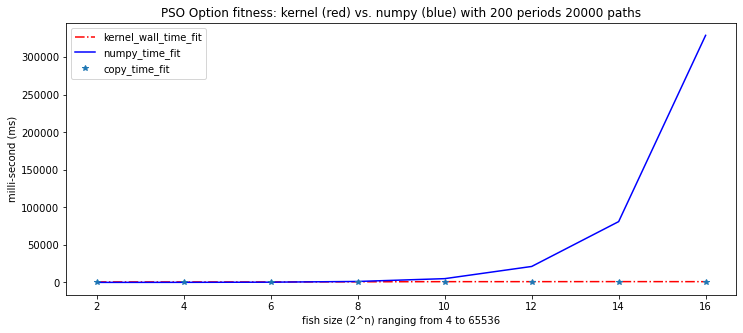

In [190]:
nfish = np.array(fish_size)
x = np.arange(min_exp, max_exp, step, dtype=int)
fig = plt.figure(figsize=(12,5))
plt.plot(x, np.array(kernel_wall_time_fit), 'r-.', label='kernel_wall_time_fit')
plt.plot(x, np.array(numpy_time_fit), 'b-', label='numpy_time_fit')
plt.plot(x, np.array(copy_time_fit), '*', label='copy_time_fit')

print('fish size:', nfish)
print('kernel wall time in ms:', kernel_wall_time_fit)
print('numpy runtime in ms:', numpy_time_fit)
print('copy time in ms:', copy_time_fit)
plt.legend(loc='best')
plt.ylabel('milli-second (ms)')
plt.xlabel('fish size (2^n) ranging from %d to %d'%( min(nfish), max(nfish) ) )
plt.title('PSO Option fitness: kernel (red) vs. numpy (blue) with %d periods %d paths'%(nPeriod, nPath))
plt.show()

##### searchGrid: particle move

In [48]:
def measureMoveParticle(min_exp, max_exp, step, S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish):
    cpuMC = cpuMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype)
    gpuMC = gpuMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish)
    
    copy_time = []
    kernel_wall_time = []
    numpy_time = []
    fish_size = []
    
    print('PSO with %d particles and %d dimensions' % (nFish, nPeriod))
    
    for exponent in range(min_exp, max_exp, step):  # This bit shift << operation does 'two to the exponent' (2^exponent)
        nFish = 1 << exponent            # 相当于 2 ** max_exp
        fish_size.append(nFish)
        print("exponent @ %s with nFish set to %d" %(exponent, nFish))
        
        # initialize data
        position = np.random.uniform(size=(nPeriod, nFish)).astype(np.float32) * 100
        velocity = np.random.uniform(size=(nPeriod, nFish)).astype(np.float32) * 5
        r1 = np.random.uniform(size=(nPeriod, nFish)).astype(np.float32)
        r2 = np.random.uniform(size=(nPeriod, nFish)).astype(np.float32)
        
        gpuPso = gpuPSO(nPeriod, nFish, 30, gpuMC.getPsoAmerOption, position, velocity, r1, r2)
        cpuPso = cpuPSO(nPeriod, nFish, 30, cpuMC.getPsoAmerOption, position, velocity, r1, r2)
        
        # ----> run kernel
        ts = time.time()
        gpuPso.searchGrid()
        evt_copy_pos = cl.enqueue_copy(gpu_queue, position, gpuPso.pos_d)
        evt_copy_vel = cl.enqueue_copy(gpu_queue, velocity, gpuPso.vel_d)
        evt_copy_pos.wait()
        evt_copy_vel.wait()
#         gpu_queue.finish()
        
        walltime = (time.time() - ts)*1e3
        copytime = ((evt_copy_pos.profile.end - evt_copy_pos.profile.start) + \
                    (evt_copy_vel.profile.end - evt_copy_vel.profile.start))*1e-6
        
        copy_time.append(round(copytime, 4))
        kernel_wall_time.append(round(walltime, 4))
        
        # ----> run benchmark
        ts = time.time()
        cpuPso.searchGrid()
        numpytime = (time.time() - ts)*1e3
        numpy_time.append(round(numpytime, 4))

        # cleanup device memory
        gpuPso.cleanUp()
    # cleanup device memory
    gpuMC.cleanUp()

    return copy_time, kernel_wall_time, numpy_time, fish_size


In [49]:
min_exp, max_exp, step = 2, 17, 2
copy_time_srh, kernel_wall_time_srh, numpy_time_srh, fish_size =  measureMoveParticle(min_exp, max_exp, step, S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish)


PSO with 500 particles and 200 dimensions
exponent @ 2 with nFish set to 4
exponent @ 4 with nFish set to 16
exponent @ 6 with nFish set to 64
exponent @ 8 with nFish set to 256
exponent @ 10 with nFish set to 1024
exponent @ 12 with nFish set to 4096
exponent @ 14 with nFish set to 16384
exponent @ 16 with nFish set to 65536


fish size: [    4    16    64   256  1024  4096 16384 65536]
kernel wall_time in ms: [3.4521, 2.5022, 6.0821, 2.6619, 8.5521, 22.0664, 21.348, 102.9513]
numpy runtime in ms: [0.1712, 0.1421, 0.6382, 1.0262, 4.169, 22.7191, 101.0499, 432.8551]
copy time in ms: [0.0142, 0.0139, 0.0166, 0.0196, 0.0565, 0.3076, 1.0901, 3.667]


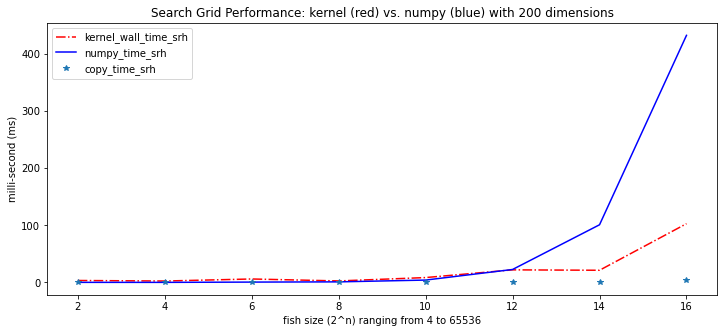

In [192]:
nfish = np.array(fish_size)
x = np.arange(min_exp, max_exp, step, dtype=int)
fig = plt.figure(figsize=(12,5))
plt.plot(x, np.array(kernel_wall_time_srh), 'r-.', label='kernel_wall_time_srh')
plt.plot(x, np.array(numpy_time_srh), 'b-', label='numpy_time_srh')
plt.plot(x, np.array(copy_time_srh), '*', label='copy_time_srh')

print('fish size:', nfish)
print('kernel wall_time in ms:', kernel_wall_time_srh)
print('numpy runtime in ms:', numpy_time_srh )
print('copy time in ms:', copy_time_srh)

plt.legend(loc='best')
plt.ylabel('milli-second (ms)')
plt.xlabel('fish size (2^n) ranging from %d to %d'%( min(nfish), max(nfish) ) )
plt.title('Search Grid Performance: kernel (red) vs. numpy (blue) with %d dimensions'%(nPeriod))
plt.show()